In [85]:
import torch 
import numpy as np
import pandas as pd
import random
import json
from matplotlib import pyplot as plt
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
import torch.nn as nn
from pathlib import Path
from sklearn.metrics import roc_auc_score

In [98]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,Sequential,GATConv,GATv2Conv,Linear,Sequential

In [86]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

In [87]:
train_data_file = "./dataset/train_sub-graph_tensor.pt"
data = torch.load(train_data_file)
train_mask = np.load("./dataset/train_mask.npy")

In [88]:
data.keys,train_mask.shape

(['label', 'feature', 'edge_index'], (39357,))

In [89]:
data.edge_index.shape,data.feature.shape,data.label.shape

(torch.Size([2, 6784824]), torch.Size([39357, 10]), torch.Size([15742]))

In [90]:
print("num_nodes:",data.num_nodes)
print("num_edge:",data.num_edges)

num_nodes: 39357
num_edge: 6784824


/home/samuel/.conda/envs/gcn/lib/python3.8/site-packages/torch_geometric/data/storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'label', 'feature', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [91]:
data.train_mask = np.zeros(len(train_mask))
data.test_mask= np.zeros(len(train_mask))
split_len = int(len(train_mask)/5*4)
data.train_mask[:split_len] = train_mask[:split_len]
data.test_mask[split_len:] = train_mask[split_len:]
data.train_mask =data.train_mask.astype(bool)
data.test_mask =data.test_mask.astype(bool)

In [92]:
data.train_mask.sum() ,data.test_mask.sum()

(12569, 3173)

In [93]:
data.train_mask.shape,data.test_mask.shape

((39357,), (39357,))

In [94]:
label = data.label
data.train_label = label[:12569]
data.test_label = label[12569:]
data.train_label.shape,data.test_label.shape

(torch.Size([12569]), torch.Size([3173]))

In [95]:
print("train positive label ratio:",data.train_label.sum(),data.train_label.sum()/len(data.train_mask))
print("val positive label ratio:",data.test_label.sum(),data.test_label.sum()/len(data.test_mask))

train positive label ratio: tensor(455) tensor(0.0116)
val positive label ratio: tensor(266) tensor(0.0068)


In [96]:
# for data augmentation
data.x = data.feature
data.y =data.label

In [97]:
class GNN(torch.nn.Module):
    def __init__(self,seed,hidden_size,dropout):
        super().__init__()
        torch.manual_seed(seed)
        self.layers = Sequential('x, edge_index', [
                    (GCNConv( 10, hidden_size), 'x, edge_index -> x'),
                    nn.ReLU(inplace=True),
                    (GCNConv(hidden_size, hidden_size*2), 'x, edge_index -> x'),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=dropout),
                    (GCNConv(hidden_size*2, hidden_size), 'x, edge_index -> x'),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=dropout),
                    (GCNConv(hidden_size, hidden_size), 'x, edge_index -> x'),
                    Linear(hidden_size, hidden_size*4),
                    nn.Dropout(p=dropout),
                    nn.ReLU(),
                    Linear(hidden_size*4, hidden_size*4),
                    nn.ReLU(),
                    Linear(hidden_size*4, 1),
        ])
    def forward(self, data):
        x, edge_index = data.feature.to(torch.float), data.edge_index
        x = self.layers(x,edge_index)
        return torch.sigmoid(x)

In [84]:
class GAT(torch.nn.Module):
    def __init__(self, seed,hidden_size, heads, dropout):
        super().__init__()
        torch.manual_seed(seed)
        self.layers = Sequential('x, edge_index', [
                    (GATConv( 10, hidden_size, heads, dropout), 'x, edge_index -> x'),
                    nn.ELU(inplace=True),
                    (GATConv(hidden_size*heads, hidden_size*2, heads, dropout), 'x, edge_index -> x'),
                    nn.ELU(inplace=True),
                    (GATConv(hidden_size*heads*2,hidden_size*2, heads,dropout), 'x, edge_index -> x'),
                    nn.ELU(inplace=True),
                    (GATConv(hidden_size*heads*2, hidden_size, heads=1,dropout=0.7), 'x, edge_index -> x'),
                    nn.ELU(inplace=True),
                    Linear(hidden_size, hidden_size*4),
                    nn.Dropout(p=dropout),
                    nn.ReLU(),
                    Linear(hidden_size*4, hidden_size*4),
                    nn.Dropout(p=dropout),
                    nn.ReLU(),
                    Linear(hidden_size*4, 1),
        ])
    def forward(self, data):
        x, edge_index = data.x.to(torch.float), data.edge_index
        x =self.layers(x, edge_index)
        return torch.sigmoid(x)

In [99]:
import grafog.transforms as T
edge_aug = T.Compose([
    T.EdgeDrop(p=0.15),
])

In [100]:
def train_step(model,data, opt, loss_function):
    model.train()
    out= model(data)
    loss = loss_function(out[data.train_mask].squeeze(), data.y[:12569].float())
    roc_score = roc_auc_score(data.y[:12569].detach().cpu().numpy(), out[data.train_mask].squeeze().detach().cpu().numpy())
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss.item() ,roc_score
def val_step(model,data, loss_function):
    model.eval()
    with torch.inference_mode():
        out = model(data)
        loss = loss_function(out[data.test_mask].squeeze(), data.y[12569:].float())
        # pred = torch.round(out[data.val_mask].squeeze())
        roc_score = roc_auc_score(data.y[12569:].detach().cpu().numpy(), out[data.test_mask].squeeze().detach().cpu().numpy())
    return loss.item() ,roc_score

In [101]:
def train(epochs,model, data, opt, loss_function, model_name,scheduler=None):
    results ={
            "train_loss":[],
            "train_roc":[],
            "val_loss":[],
            "val_roc":[]
    }
    for epoch in range(epochs):
        new_data = edge_aug(data)
        train_loss, train_roc_score = train_step(model, new_data, opt, loss_function)
        val_loss, val_roc_score = val_step(model, data, loss_function)
        if scheduler:
            scheduler.step()
        if (epoch+1)%5==0:
            print(
              f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} |"
              f"train_roc: {train_roc_score:.4f} |"  
              f"val_loss: {val_loss:.4f} |"
              f"val_roc: {val_roc_score:.4f} |" 
               
            )
        if (epoch+1)%20==0:
            MODEL_PATH = Path("./model/"+ model_name)
            MODEL_PATH.mkdir(parents=True, 
                             exist_ok=True
            )
            MODEL_NAME = f"model_{epoch+1}.pth"
            MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
            print(f"Saving model to: {MODEL_SAVE_PATH}")
            torch.save(obj=model,
                       f=MODEL_SAVE_PATH)
        results["train_loss"].append(train_loss)
        results["train_roc"].append(train_roc_score)
        results["val_loss"].append(val_loss)
        results["val_roc"].append(val_roc_score)
    MODEL_PATH = Path("./model/"+ model_name)
    MODEL_PATH.mkdir(parents=True, 
                     exist_ok=True
    )
    MODEL_NAME = f"model_final.pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model,
               f=MODEL_SAVE_PATH)

    return results

In [102]:

model = GAT(2,16,1,0.7)
model.to(device)
LR = 1e-3
EPOCH =1000
opt = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=900, gamma=0.5)
data = data.to(device)
loss_function = nn.BCELoss()
res = train(EPOCH,model, data, opt, loss_function, model_name="GATv2_v4",scheduler=scheduler)

Epoch: 5 | train_loss: 2.1591 |train_roc: 0.4886 |val_loss: 0.3040 |val_roc: 0.6516 |
Epoch: 10 | train_loss: 0.6868 |train_roc: 0.4927 |val_loss: 0.3261 |val_roc: 0.6150 |
Epoch: 15 | train_loss: 0.4770 |train_roc: 0.3790 |val_loss: 0.3361 |val_roc: 0.5176 |
Epoch: 20 | train_loss: 0.3906 |train_roc: 0.3772 |val_loss: 0.3637 |val_roc: 0.3270 |
Saving model to: model/GATv2_v4/model_20.pth
Epoch: 25 | train_loss: 0.2648 |train_roc: 0.4979 |val_loss: 0.3402 |val_roc: 0.5125 |
Epoch: 30 | train_loss: 0.2454 |train_roc: 0.5521 |val_loss: 0.3370 |val_roc: 0.6213 |
Epoch: 35 | train_loss: 0.2313 |train_roc: 0.6062 |val_loss: 0.3181 |val_roc: 0.6402 |
Epoch: 40 | train_loss: 0.2165 |train_roc: 0.5894 |val_loss: 0.2961 |val_roc: 0.6295 |
Saving model to: model/GATv2_v4/model_40.pth
Epoch: 45 | train_loss: 0.2176 |train_roc: 0.5602 |val_loss: 0.2879 |val_roc: 0.6250 |
Epoch: 50 | train_loss: 0.1989 |train_roc: 0.6178 |val_loss: 0.2819 |val_roc: 0.6415 |
Epoch: 55 | train_loss: 0.2017 |train_roc

KeyboardInterrupt: 

<Axes: >

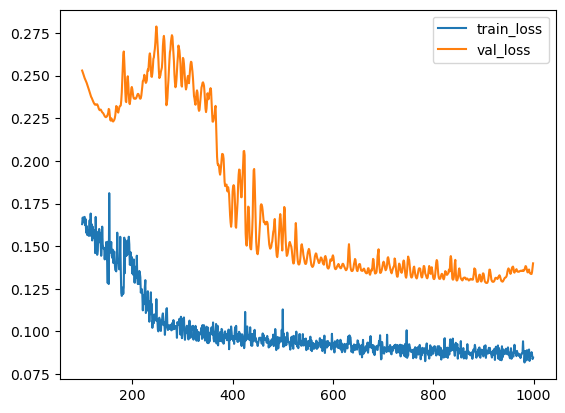

In [83]:
pd.DataFrame(res).iloc[100:,[0,2]].plot()

<Axes: >

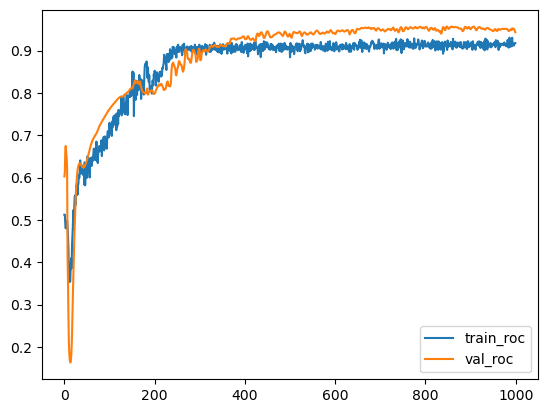

In [46]:
pd.DataFrame(res).iloc[:,[1,3]].plot()

# Testing

In [70]:
def test(model, test_data):
    model.eval()
    out = model(test_data)
    pred = out[test_data.mask].squeeze()
    index = np.where(test_data.mask)[0]
    return pd.DataFrame({"node idx":index,"node anomaly score":pred.detach().cpu().numpy()})
    

In [71]:
test_data = torch.load("./dataset/test_sub-graph_tensor_noLabel.pt")
test_data.mask = np.load("./dataset/test_mask.npy")
test_data.x= test_data.feature
test_data.to(device)

Data(edge_index=[2, 7000540], feature=[39357, 10], mask=[39357], x=[39357, 10])

In [80]:
model = torch.load("model.pth")

In [81]:
output = test(model,test_data)

In [82]:
output['node anomaly score'].sum()

1200.1326

In [76]:
test_data.mask.sum(),len(test_data.mask)

(15823, 39357)

In [69]:
output.to_csv("submission.csv",index =False)